# Data

* 63 ảnh toàn cảnh **Landsat 8 OLI**
* Sử dụng 3 kênh màu: **Blue - Red - NIR** (cận hồng ngoại, nước phản xạ thấp ở dải phổ này)
* Nhãn được tạo tự động từ các vùng đa giác nước của **OSM** (OpenStreetMap)
* Sau quá trình lọc bỏ (Sai lệch so với OSM, không chưa lớp đất, nước, che phủ bởi mây):
    * Tổng cộng **1008** ảnh con
    * **Train: 824** (80%)
    * **Validation: 92** (10%)
    * **Test: 92** (10%)

*bộ dữ liệu* **YTU-WaterNet** *này được công khai tại: http://www.remotesensinglab.yildiz.edu.tr/*

# Method

Majority voting để ensembling 5 architectures:
* Standard U-Net
* FC-DenseNet
* Fractal U-Net
* Dilated U-Net
* Pix2Pix

* Sử dụng **AWEI** để làm based method so sánh

## Standard U-Net

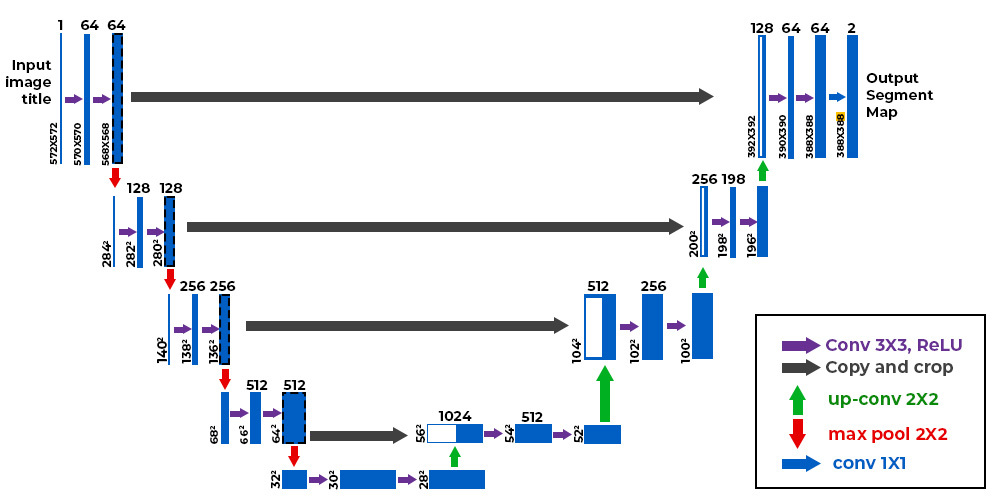

* Là một mạng CNN đối xứng gồm 2 thành phần chính:
    * **Encoder**: Trích xuất đặc trưng từ ảnh đầu vào, sử dụng các lớp tích chập và pooling để giảm kích thước
    * **Decoder**: Phục hồi ảnh bằng các lớp upsampling + thông tin từ **Encoder**

* Đặc điểm chính:
    * **Skip connections**: nối tắt (copy and crop) giúp giảm mất mát thông tin khi truyển từ `encoder` sang `decoder`
    * **max pooling** để giảm kích thước, **up-convolution** để tăng kích thước
    * **Convolution 3x3, ReLU** để trích xuất đặc trưng
    * **Convolution 1x1** cuối cùng để đưa số kênh đầu ra

## Dilated U-Net

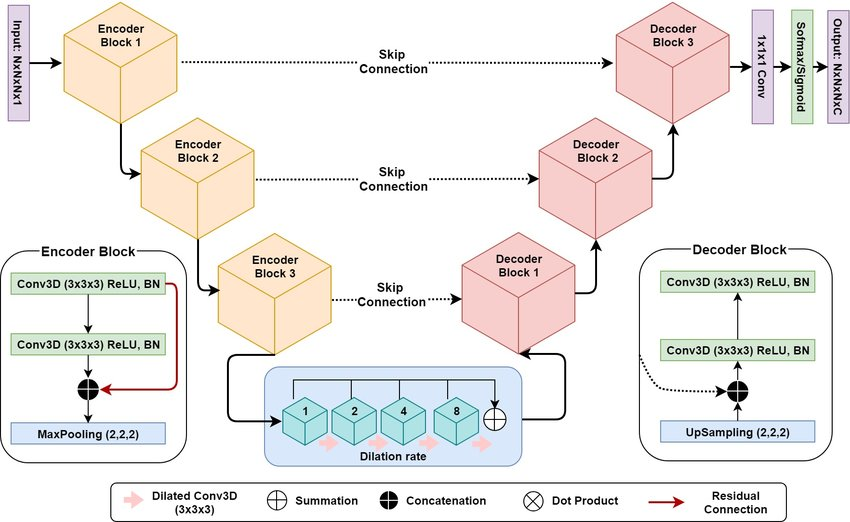

*Hình ảnh minh họa, không giống y hệt cấu trúc*

* **Encoder**: 4 khối tích chập, không sử dụng **pooling**
* **Pyramid Dilation**: ở cuối Encoder với dilation rate: 2,4,6  
$$ y[i] = \sum^{K-1}_{k=0}x[i+r.k]w[k] $$
trong đó:
    * $r$ là hệ số giãn cách (dilation rate, r=1 là tích chập thông thường)
    * $x$ là ảnh đầu vào
    * $w$ là bộ lọc

* **Encoders**: 64 filters ở mọi lớp (?)
* **Decoders**: 128, 64, 128, 64 filters (?)
* **Output**: Softmax

> Sử dụng nhiều memory hơn U-Net

## Fractal U-Net

* FractalNet: ultra-deep neural network: mạng siêu sâu mà không cần học phần dư (residual) như **ResNet**, sử dụng **cấu trúc phân dạng (fractal architecture)** với nhiều nhánh có độ sâu khác nhau

* Kiến trúc **Fractal U-Net** là sự kết hợp của 2 mạng **U-Net**:
    * **Feature maps** từ decoder của U-Net thứ nhất được **merged** với encoder của U-Net thứ hai (?)
    * Scale sizes: (512x512), (256x256), (128x128), (64x64), (32x32)
    * Filters in convolution layers: 16, 32, 64, 128, 256
    * Activation function: ReLU

## FC-DenseNet

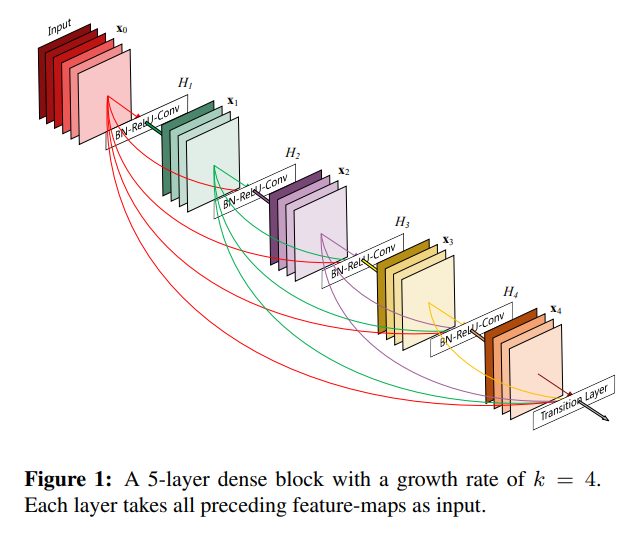

*Hình ảnh minh họa DenseNet*

* **Dense Block** : 
    * Mỗi lớp convolution kết nối với tất cả các lớp trước đó
    * Đầu ra của lớp trước trở thành đầu vào của tất cả các lớp sau
    * Tránh được **vanishing gradient**

* **FC-DenseNet Architecture**:
    * Encoder:
        * Chứa **Dense Blocks có nhiều lớp conv 3x3
        * Giữa các **Dense Blocks** có BN, ReLU, 2x2 MaxPooling (stride 2) để giảm kích thước ảnh
    * Decoder:
        * 2x2 Up-convolution (transposed convolution) để tăng kích thước ảnh
        * Feature maps từ encoder được concatenation với feature maps tương ứng từ decoder
        * Sau đó, áp dụng **Dense Blocks** tiếp
    * Output:
        * 1x1 conv + Sigmoid để phân loại từng pixel

* FC-DenseNet56:
    * 56 lớp
    * Mỗi **Dense Blocks** có 4 lớp convolution

## Pix2pix

*Là một mô hình GAN (Generative Adversarial Network) có điều kiện (cGAN) được sử dụng cho* **Image-to-Image Translation**

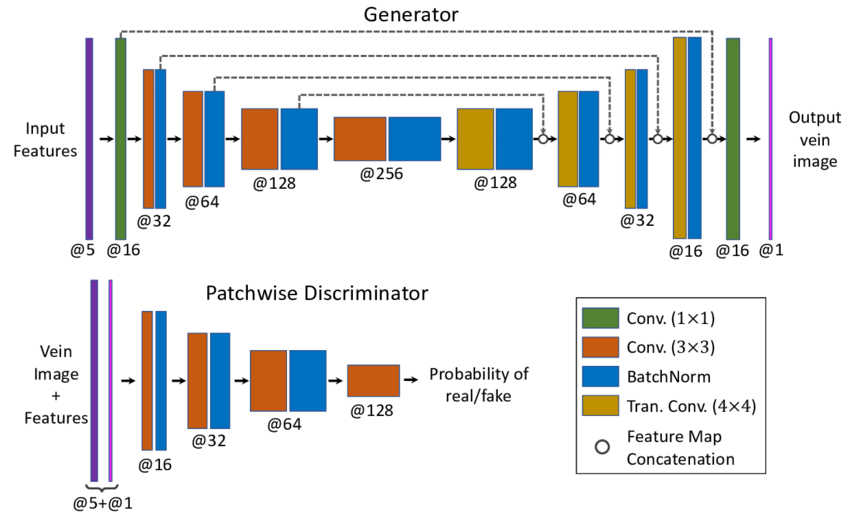

🔗**Architecture**:
* **Generator** (bộ sinh ảnh):
    * 1 ảnh đầu vào, tạo ra 1 ảnh mới tương ứng
    * Dựa trên **U-Net** có một số thay đổi:
        * Không dùng max-pooling layers
        * Conv 4x4 với Leaky ReLU thay vì 3x3 với ReLU
        * Transposed Convolution thay vì upsampling để khôi phục
* **Discriminator** (bộ phân biệt):
    * Nhận vào 1 cặp ảnh (ảnh thực, ảnh gen) đánh giá xem ảnh sinh ra có giống ảnh thật không
    * Dùng **PatchGan** thay vì toàn bộ ảnh, giúp phân biệt trên các vùng nhỏ (patches)
    * Có kiến trúc giống CNN với **4x4 Conv + Leaky ReLU**

⚙️**Cơ chế huấn luyện**: adversarial training: đối kháng
* **Generator** cố gắng tạo ảnh càng giống thật càng tốt để đánh lừa **Discriminator**
* **Discriminator** cố gắng phân biệt thật giả
* Cả 2 mạng đề cải thiện dần trong quá trình train -> ảnh đầu ra ngày càng chất lượng

⚖️**Hàm mất mát tổng hợp**:  
$$ L_{Pix2Pix} = L_{GAN} + \lambda L_{L1} $$

* **GAN Loss**: Đánh giá mức độ đánh lừa được Discriminator.
* **L1 Loss**: Giữ cho ảnh sinh ra có cấu trúc tương tự ảnh gốc.

# Results

* **Strategies**:
    * Adam optimization
    * Learning rate: 0.0002
    * Loss functin: Binary Cross-entropy
    * Epochs: 100

* **Traning times**:  ( Nvidia GeForce® GTX 1080Ti 11GB GDDR5X)
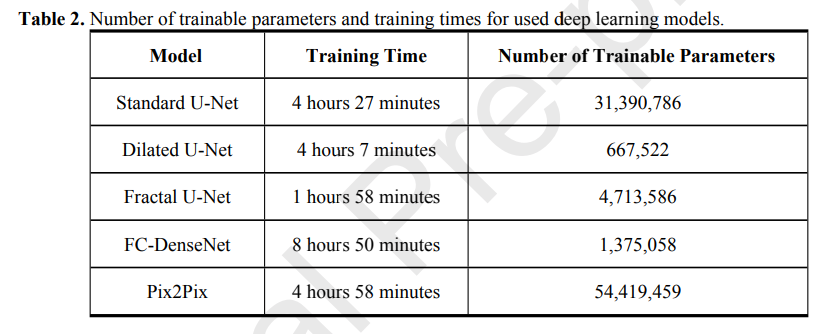

* **Accuracy**:  
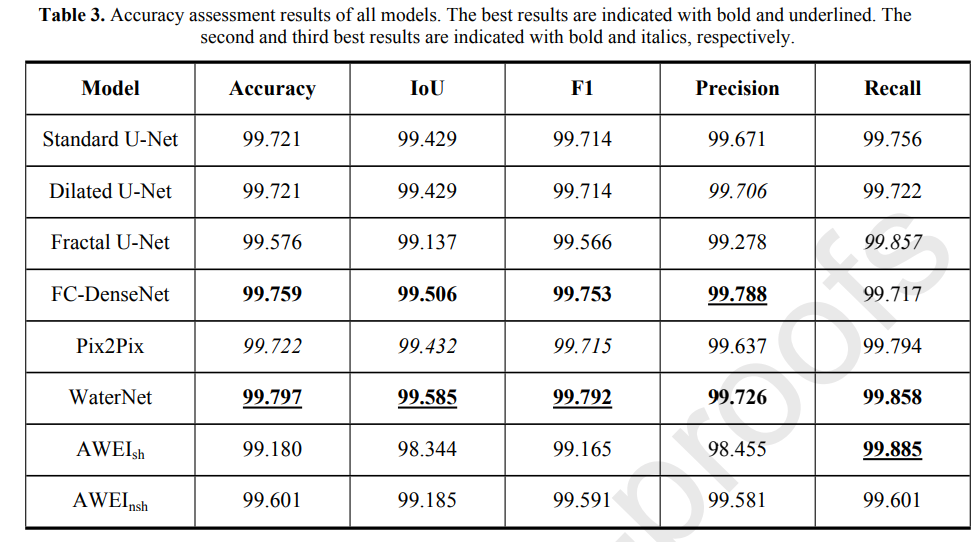